In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from stop_words import get_stop_words
import re
import numpy as np
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix#, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from  sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns


main_df = pd.read_csv(r'C:\Users\Jpamb\Desktop\AIQ1\complaints-2021-09-08_07_12.csv')


# creating a list of extra stop-words as these repeatedly appear in all complaints
# xxxx is used in the data to hide sensitive information
stplist = ['title', 'body', 'xxxx']
english_stopwords = get_stop_words(language='english')
english_stopwords += stplist
english_stopwords = list(set(english_stopwords))

def get_wordnet_pos(word):
    """
    Function that determines the the Part-of-speech (POS) tag.
    Acts as input to lemmatizer
    """
    if word.startswith('N'):
        return wn.NOUN
    elif word.startswith('V'):
        return wn.VERB
    elif word.startswith('J'):
        return wn.ADJ
    elif word.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN


def clean_up(text):
    """
    Function to clean data.
    Steps:
    - Removing special characters, numbers
    - Lemmatization
    - Stop-words removal
    - Getting a unique list of words
    """
    lemmatizer = nltk.WordNetLemmatizer().lemmatize
    text = re.sub('\W+', ' ', str(text))
    text = re.sub(r'[0-9]+', '', text.lower())
    
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    normalized_text_lst = [lemmatizer(x[0], get_wordnet_pos(x[1])).lower() for x in word_pos]
    stop_words_free = [i for i in normalized_text_lst if i not in english_stopwords and len(i) > 3]
    stop_words_free = list(set(stop_words_free))
    return(stop_words_free)

In [2]:
df = main_df
df = df[['Product', 'Consumer complaint narrative']]

df = df[pd.notnull(df['Consumer complaint narrative'])]
df = df.rename({'Consumer complaint narrative':'complaint', 'Product':'product'},
               axis='columns')

products_count_df = df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)

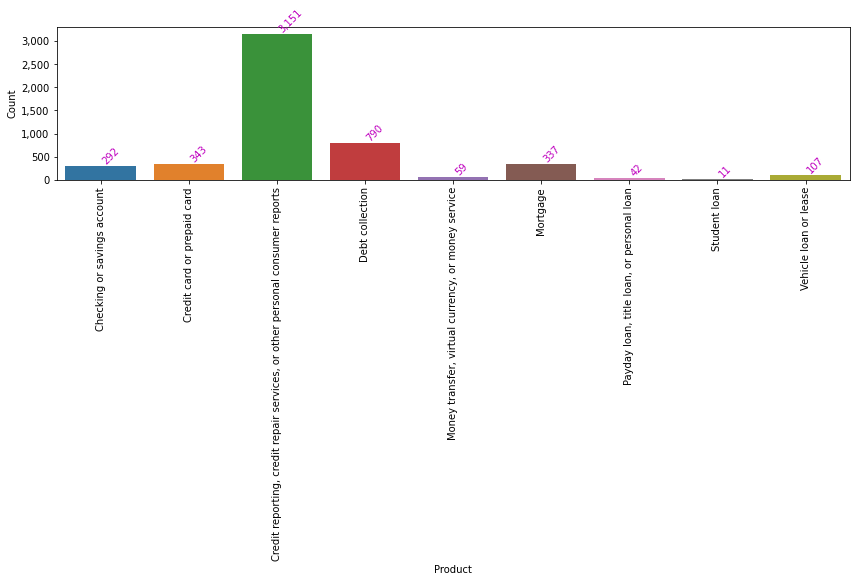

In [3]:
plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(products_count_df['product'], products_count_df['complaint'])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Product", ylabel='Count')
ax.set_xticklabels(products_count_df['product'])
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(products_count_df["complaint"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing of Data

In [4]:
df['complaint'] = df['complaint'].apply(clean_up)
df.to_csv("C:/Users/Jpamb/Desktop/AIQ1/Level B/output_consumer_complaints.csv", index=False)
# ---

# Loading this from the saved version of this file.
input_df = pd.read_csv(r"C:/Users/Jpamb/Desktop/AIQ1/Level B/output_consumer_complaints.csv", 
                       converters={"complaint": literal_eval})
input_df.head()

,product,complaint
0,"Credit reporting, credit repair services, or o...","[attorney, court, active, even, obtain, fraudu..."
1,"Credit reporting, credit repair services, or o...","[tell, court, submit, even, take, original, th..."
2,"Credit reporting, credit repair services, or o...","[take, immediately, list, deal, address, conta..."
3,Debt collection,"[allege, attorney, damage, entirety, refuse, p..."
4,"Credit reporting, credit repair services, or o...","[unable, fraudulent, settle, proof, partial, d..."


In [5]:
# Some rows have been stripped of words after the cleaning process and contain empty lists
# These have to be removed as they don't help in the prediction problem at all.
print("Removing rows which have been stripped of words after the cleaning process. These contain empty lists:")
print("Before: ", input_df.shape)
input_df = input_df[input_df.astype(str)['complaint'] != '[]']
print("After: ", input_df.shape)
bow_input_df = input_df

Removing rows which have been stripped of words after the cleaning process. These contain empty lists:
Before:  (5132, 2)
After:  (5132, 2)


#### Bag of Words Model

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import array

min_word_count = 10
products_count_df = bow_input_df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)
class_labels = array(products_count_df['product'].unique())

In [7]:
# TfidfVectorizer handles tokenization.
bow_input_df['complaints_untokenized'] = bow_input_df['complaint'].apply(lambda x: ' '.join(x))

tfidf_converter = TfidfVectorizer(max_features=1500, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                                  stop_words='english')
features = tfidf_converter.fit_transform(bow_input_df.complaints_untokenized).toarray()
labels = class_labels

## Training and Test Sets

In [8]:
train_x, test_x, train_y, test_y = train_test_split(features, bow_input_df['product'], test_size=0.3,
                                                    random_state=123)

## Modelling

Models implemented:

1. Naive Bayes
2. Random Forest
3. Linear SVC

In [9]:
# Model 1: Naive Bayes model
bayes_model = MultinomialNB()
bayes_clf = bayes_model.fit(train_x, train_y)

In [10]:
naive_preds = bayes_clf.predict(test_x)
naive_preds_conf = bayes_clf.predict_proba(test_x)
naive_preds_conf_df = pd.DataFrame(naive_preds_conf, index=range(naive_preds_conf.shape[0]),
                          columns=range(naive_preds_conf.shape[1]))
naive_preds_conf_df['predicted_conf'] = naive_preds_conf_df.max(axis=1)
naive_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":naive_preds})

naive_results = pd.concat([naive_results, naive_preds_conf_df['predicted_conf']], axis=1)
# Accuracy: wherever the labels were correctly predicted.
naive_results['correctly_predicted'] = np.where(naive_results['actual_label'] == naive_results['predicted_label'], 
                                                1, 0)
naive_accuracy = (naive_results['correctly_predicted'].sum()/naive_results.shape[0])*100
print("Accuracy of Naive Bayes is: {0:.2f}.".format(naive_accuracy))

Accuracy of Naive Bayes is: 42.42.


In [11]:
print(metrics.classification_report(test_y, naive_preds, target_names=bow_input_df['product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.63      0.44      0.52        95
                                                             Debt collection       0.70      0.38      0.49       106
                                                 Checking or savings account       0.73      0.97      0.83       930
                                                                    Mortgage       0.77      0.26      0.39       250
                                                 Credit card or prepaid card       0.00      0.00      0.00        16
                          Money transfer, virtual currency, or money service       0.76      0.63      0.69       104
                                                       Vehicle loan or lease       0.00      0.00      0.00         6
                                   Payday loan, title l

In [12]:
# Model 2: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators = 100, max_features='sqrt', verbose=1, warm_start=False,
                                 random_state=123) #ntrainDataVecs=4, max_depth=2)
rf_clf = rf_model.fit(train_x, train_y)
rf_preds = rf_clf.predict(test_x)
rf_preds_conf = rf_clf.predict_proba(test_x)
rf_preds_conf_df = pd.DataFrame(rf_preds_conf, index=range(rf_preds_conf.shape[0]),
                          columns=range(rf_preds_conf.shape[1]))

rf_preds_conf_df['predicted_conf'] = rf_preds_conf_df.max(axis=1)
rf_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":rf_preds})
rf_results = pd.concat([rf_results, rf_preds_conf_df['predicted_conf']], axis=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [13]:
# Accuracy: wherever the labels were correctly predicted.
rf_results['correctly_predicted'] = np.where(rf_results['actual_label'] == rf_results['predicted_label'], 1, 0)
rf_accuracy = (rf_results['correctly_predicted'].sum()/rf_results.shape[0])*100
print("Accuracy of Random Forest obtained is: {0:.2f}.".format(rf_accuracy))
print(metrics.classification_report(test_y, rf_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Random Forest obtained is: 46.75.
                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.68      0.71      0.69        95
                                                             Debt collection       0.76      0.54      0.63       106
                                                 Checking or savings account       0.80      0.97      0.88       930
                                                                    Mortgage       0.85      0.52      0.65       250
                                                 Credit card or prepaid card       0.00      0.00      0.00        16
                          Money transfer, virtual currency, or money service       0.83      0.73      0.78       104
                                                       Vehicle loan or lease       0.00      0.00      0.00         6
         

In [14]:
# Model 3: Linear Support Vector Machine
svc_model = LinearSVC()
svcc_model = CalibratedClassifierCV(svc_model)     
svc_clf = svcc_model.fit(train_x, train_y)
svc_preds = svcc_model.predict(test_x)
svc_preds_conf = svcc_model.predict_proba(test_x)
svc_preds_conf_df = pd.DataFrame(svc_preds_conf, index=range(svc_preds_conf.shape[0]), 
                                columns=range(svc_preds_conf.shape[1]))
svc_preds_conf_df['predicted_conf'] = svc_preds_conf_df.max(axis=1)
svc_results = pd.DataFrame(data={'actual_label':test_y, 'predicted_label':svc_preds})

svc_results = pd.concat([svc_results, svc_preds_conf_df['predicted_conf']],axis=1)

In [15]:
# Accuracy: wherever the labels were correctly predicted.
svc_results['correctly_predicted'] = np.where(svc_results['actual_label'] == svc_results['predicted_label'], 1, 0)
svc_results.head()
svc_accuracy = (svc_results['correctly_predicted'].sum()/svc_results.shape[0])*100
print("Accuracy of Linear SVC obtained is: {0:.2f}.".format(svc_accuracy))
print(metrics.classification_report(test_y, svc_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Linear SVC obtained is: 48.23.
                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.69      0.75      0.72        95
                                                             Debt collection       0.74      0.55      0.63       106
                                                 Checking or savings account       0.87      0.94      0.90       930
                                                                    Mortgage       0.76      0.68      0.72       250
                                                 Credit card or prepaid card       0.50      0.25      0.33        16
                          Money transfer, virtual currency, or money service       0.81      0.82      0.81       104
                                                       Vehicle loan or lease       0.00      0.00      0.00         6
            

#### Comparison between the models implemented
- Of the Bag of Words models implemented, Linear SVC has the best accuracy

#### Accuracies
- Naive Bayes - 42.42
- Random Forest - 46.75
- Linear SVC - 48.23

-----------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------